In [1]:
%matplotlib widget
import os
import numpy as np
import h5py

tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
results_dir = '/DATA2/microvascular/cylinder/orientation/outputs/'
def read_results(filename):
    signal_magnitude = []       
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])                
        S = np.array(h5['scales'])  
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            M_f = M[ids, mask, 0, :]             
            M_f = np.sum(M_f[...,0:2], axis=0)            
            signal_magnitude.append(np.linalg.norm(M_f))    
    return signal_magnitude


############
radius = 8
oxy_level = [78, 85]
orientation = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
signal_change_gre = []
for ido, ori in enumerate(orientation):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'gre_{o}_r{radius}_Y0.0_BVF{4}_ori{ori}_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change_gre.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))

signal_change_se = []
for ido, ori in enumerate(orientation):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'se_{o}_r{radius}_Y0.0_BVF{4}_ori{ori}_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change_se.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))

signal_change_ssfp = []
for ido, ori in enumerate(orientation):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'ssfp_{o}_r{radius}_Y0.0_BVF{4}_ori{ori}_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change_ssfp.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))

with h5py.File(os.path.join(results_dir, f'{filename}.h5'), 'r') as h5:
    scales = np.array(h5['scales']) 

# save as mat file
import scipy.io as sio
sio.savemat(os.path.join(results_dir, 'signal_change.mat'), {'radius':radius, 'scales':scales, 'signal_change_gre': signal_change_gre, 'signal_change_se': signal_change_se, 'signal_change_ssfp': signal_change_ssfp})


In [1]:
# load mat file
import os
import numpy as np
import scipy.io as sio
results_dir = '/DATA2/microvascular/cylinder/orientation/outputs/'
data = sio.loadmat(os.path.join(results_dir, 'signal_change.mat'))
signal_change_gre  = np.array(data['signal_change_gre'])
signal_change_se   = np.array(data['signal_change_se'])
signal_change_ssfp = np.array(data['signal_change_ssfp'])
scales = data['scales']
radius = data['radius']
print(signal_change_gre.shape, signal_change_se.shape, signal_change_ssfp.shape)

(10, 50) (10, 50) (10, 50)


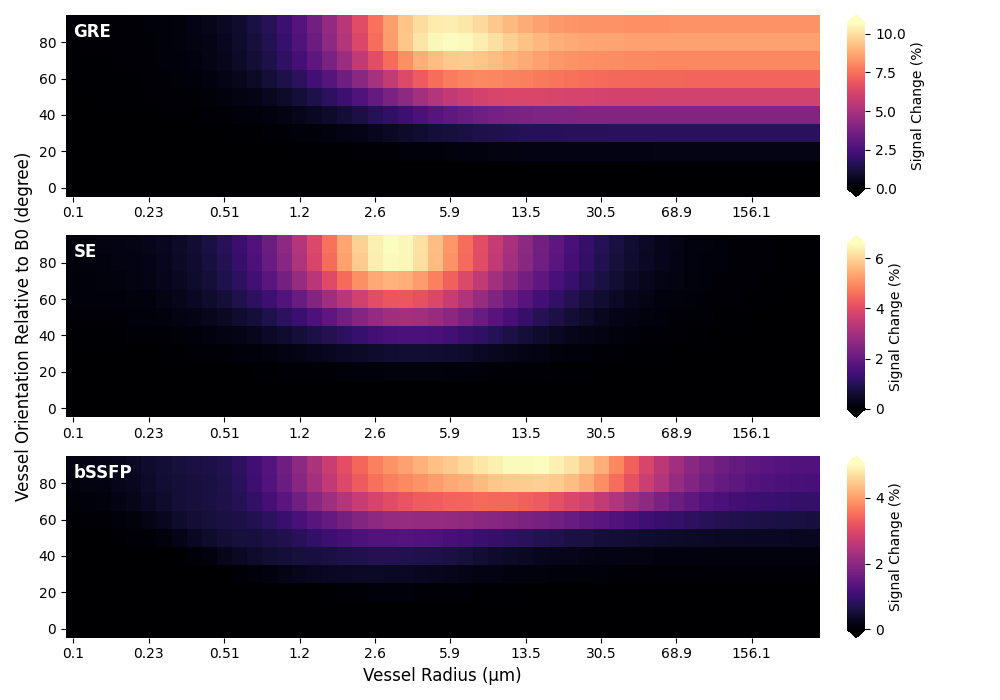

In [3]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

plt.close('all')
x = radius * scales.squeeze()
x = x.reshape(-1)
x = np.where(x < 1, np.round(x, 2), np.round(x, 1))
y_label = np.arange(0, 100, 10)

fig, axs = plt.subplots(3, 1, figsize=(10, 7))
for (ax, sig, seq_name) in zip(axs, [signal_change_gre, signal_change_se, signal_change_ssfp], ['GRE', 'SE', 'bSSFP']):
    sigt = np.nan_to_num(sig)
    im = ax.imshow(sigt, cmap = "magma", aspect='auto')
    ax.set_xticks(ticks=np.arange(x.size), labels=x)
    ax.set_yticks(ticks=np.arange(y_label.size), labels=y_label)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax.invert_yaxis()    
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.patch.set_visible(False)
    ax.text(0.01, 0.88, seq_name, transform=ax.transAxes, fontsize=12, color='white', weight='bold')

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', aspect=10, extend='both', label='Signal Change (%)', pad=0.03)
    cbar.outline.set_visible(False)

axs[2].set_xlabel('Vessel Radius (µm)', fontsize=12)
axs[1].set_ylabel('Vessel Orientation Relative to B0 (degree)', fontsize=12)

fig.patch.set_visible(False)
fig.tight_layout()
plt.savefig('./figures/orientation.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig('./figures/orientation.pdf', format='pdf', dpi=1200, bbox_inches='tight')

plt.show()